В этом соревновании вам предлагается задача из области компьютерного зрения – распознавание букв английского алфавита на искаженных и зашумленных изображениях.

**Примеры:**

![](https://lms.skillfactory.ru/asset-v1:SkillFactory+MFTIDS+SEP2023+type@asset+block@%D0%A1%D0%BD%D0%B8%D0%BC%D0%BE%D0%BA_%D1%8D%D0%BA%D1%80%D0%B0%D0%BD%D0%B0_2024-05-03_%D0%B2_19.28.33.png)

Данные для обучения содержатся в двух файлах:  `images.npy`  и  `labels.npy`. Это формат numpy-массивов.

# загрузка данных

    import numpy as np
    images = np.load('/kaggle/input/mipt-dl-captcha/data/images.npy')
    labels = np.load('/kaggle/input/mipt-dl-captcha/data/labels.npy')

Всего доступно 20 тысяч размеченных изображений размером 48x48 с 3 цветовыми каналами (RGB), поэтому массив images имеет размер (20000, 48, 48, 3). В массиве  `labels`  содержатся ответы к тренировочному набору изображений. В английском алфавите 26 букв: 0-й класс соответствует букве А и так далее по алфавиту, 25-й класс — буква Z.

Ваша задача — обучить нейронную сеть и с ее помощью предсказать метки классов для изображений из файла  `images_sub.npy`, в нем 50 тысяч изображений. Посмотрите на структуру файла  `sample_submission.csv`  — он не содержит полезных данных, а лишь описывает формат, в котором вы загружаете ваши предсказания на сайт. Создайте из ваших предсказаний такой же файл и загрузите в качестве вашего ответа (сабмита). Вы можете делать до 20 сабмитов в сутки.

Метрика лидерборда —  **accuracy**, то есть доля правильно распознанных изображений.

Нотбук с базовым решением расположен в Google Colab. Попробуйте решить задачу, не обращаясь к нему. Задача будет считаться решенной, если в Public Leaderboard вы наберете  _score_, который будет равен или больше  **0.82**.

In [1]:
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
import torch.nn as nn
from sklearn.model_selection import train_test_split

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device: ", device)

Device:  cuda


In [2]:
dataset_url = 'https://www.kaggle.com/competitions/dl-captcha-new/data'
od.download(dataset_url)

Skipping, found downloaded files in "./dl-captcha-new" (use force=True to force download)


In [3]:
images = np.load('./dl-captcha-new/mds-misis-dl-captchan/images.npy')
images_sub = np.load('./dl-captcha-new/mds-misis-dl-captchan/images_sub.npy')
labels = np.load('./dl-captcha-new/mds-misis-dl-captchan/labels.npy')



In [4]:
def number_to_letter(number):
    if 1 <= number <= 26:
        return chr(number + 65)
    else:
        return None

In [5]:
num_classes = len(np.unique(labels))
# Проверка формы данных
print("Количество labels:", labels.shape[0])
print("Количество изображений:", images.shape[0])
print("Размер изображений:", images.shape[1])
print("Варианты:", num_classes)  


Количество labels: 20000
Количество изображений: 20000
Размер изображений: 48
Варианты: 26


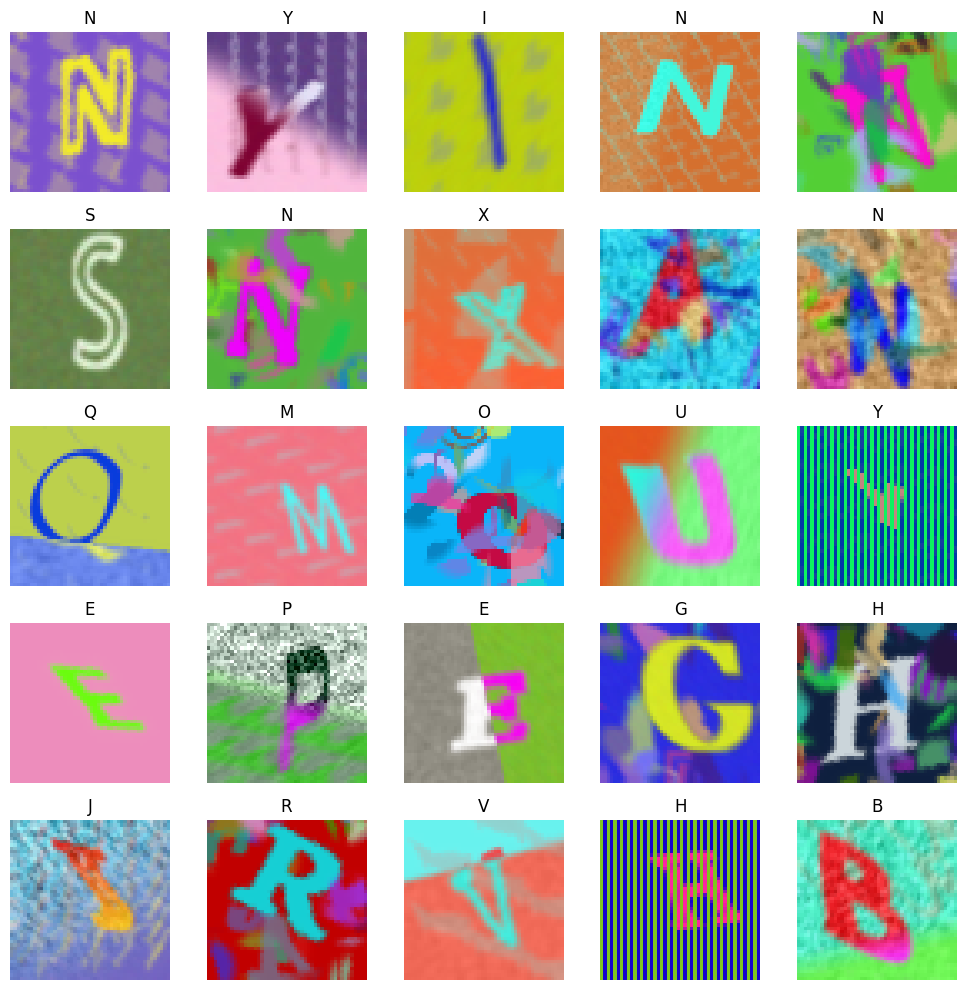

In [6]:
# Отображаем 25 случайных изображений
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(number_to_letter(labels[i]))
    plt.axis('off')
plt.tight_layout()
plt.show()

In [7]:
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedCNN, self).__init__()
        # Conv Block 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        
        # Conv Block 2
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        
        # Conv Block 3
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.global_pool = nn.AdaptiveAvgPool2d((6, 6))
        
        self.fc1 = nn.Linear(128 * 6 * 6, 512)
        self.fc_bn = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        # Block 1
        x = nn.functional.relu(self.bn1(self.conv1(x)))
        x = nn.functional.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout(x)
        
        # Block 2
        x = nn.functional.relu(self.bn3(self.conv3(x)))
        x = nn.functional.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = self.dropout(x)
        
        # Block 3
        x = nn.functional.relu(self.bn5(self.conv5(x)))
        x = nn.functional.relu(self.bn6(self.conv6(x)))
        x = self.pool(x)
        x = self.dropout(x)
        
        x = self.global_pool(x)
        x = x.view(-1, 128 * 6 * 6)
        x = nn.functional.relu(self.fc_bn(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

improvedCNN = ImprovedCNN(num_classes=num_classes).to(device)

class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 6 * 6, 512) 
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 128 * 6 * 6)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

cnnModel = CNNModel(num_classes=num_classes)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [9]:
def prepare_data(X, y=None, is_train=False):
    # Создаем трансформации
    if is_train:
        transform = transforms.Compose([
            transforms.ToPILImage(),  # Конвертируем numpy array в PIL Image
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    else:
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    # Применяем трансформации к каждому изображению (работаем с numpy array)
    X_transformed = torch.stack([transform(img) for img in X])  # X должен быть в формате (N,48,48,3)
    if y is not None:
        y_tensor = torch.from_numpy(y).long()
        return X_transformed, y_tensor
    return X_transformed

# Использование:
X_train_tensor, y_train_tensor = prepare_data(X_train, y=y_train, is_train=True)
X_test_tensor, y_test_tensor = prepare_data(X_test, y=y_test, is_train=False)
X, Y = prepare_data(images, y=labels, is_train=False)
images_sub = prepare_data(images_sub, is_train=False)

In [10]:
# Создание Dataset и DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
X_Y = TensorDataset(X, Y)
images_sub_tensor = TensorDataset(images_sub)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
X_Y_loader = DataLoader(X_Y, batch_size=batch_size, shuffle=False)
images_sub_loader = DataLoader(images_sub_tensor, batch_size=batch_size, shuffle=False)

In [11]:

from IPython.display import clear_output


def train(model, train, criterion, optimizer, num_epoch, test=None, scheduler=None):
    '''
    Улучшенная функция обучения с визуализацией процесса
    
    args:
        model - модель нейронной сети
        train - обучающая выборка
        criterion - функция потерь
        optimizer - оптимизатор
        num_epoch - количество эпох обучения
        test - валидационные данные (опционально)
    '''
    # Обучение модели с визуализацией
    model.to(device)

    # Инициализация списков для хранения метрик
    train_loss_history = []
    test_loss_history = []
    train_acc_history = []
    test_acc_history = []

    for epoch in range(num_epoch):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for inputs, labels in train:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        # Вычисление метрик для обучающего набора
        epoch_train_loss = running_loss / len(train)
        epoch_train_acc = 100 * correct_train / total_train
        
        # Валидация
        model.eval()
        test_loss = 0.0
        correct_test = 0
        total_test = 0
        if (test != None):
            with torch.no_grad():
                for inputs, labels in test:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    test_loss += loss.item()
                    
                    _, predicted = torch.max(outputs.data, 1)
                    total_test += labels.size(0)
                    correct_test += (predicted == labels).sum().item()
        if (test != None):        
            # Вычисление метрик для тестового набора
            epoch_test_loss = test_loss / len(test)
            epoch_test_acc = 100 * correct_test / total_test
        else: 
            epoch_test_loss = -1
            epoch_test_acc = -1 

        # Обновление планировщика на основе точности валидации
        if (scheduler != None):
            scheduler.step(epoch_test_acc)
        
        # Очистка вывода и построение графиков
        clear_output(wait=True)
        # После вычисления метрик на эпохе добавляем их в историю
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)
        test_loss_history.append(epoch_test_loss)
        test_acc_history.append(epoch_test_acc)
        print(f'Epoch {epoch+1}/{num_epoch}, '
            f'Train Loss: {epoch_train_loss:.4f}, '
            f'Test Loss: {epoch_test_loss:.4f}, '
            f'Train Accuracy: {epoch_train_acc:.2f}%, '
            f'Test Accuracy: {epoch_test_acc:.2f}% '
            f'Current LR: {optimizer.param_groups[0]["lr"]:.2e}'
            )
    return model, train_acc_history, test_acc_history, train_loss_history, test_loss_history

Epoch 10/10, Train Loss: 0.8010, Test Loss: 1.0545, Train Accuracy: 72.96%, Test Accuracy: 67.92% Current LR: 1.00e-03


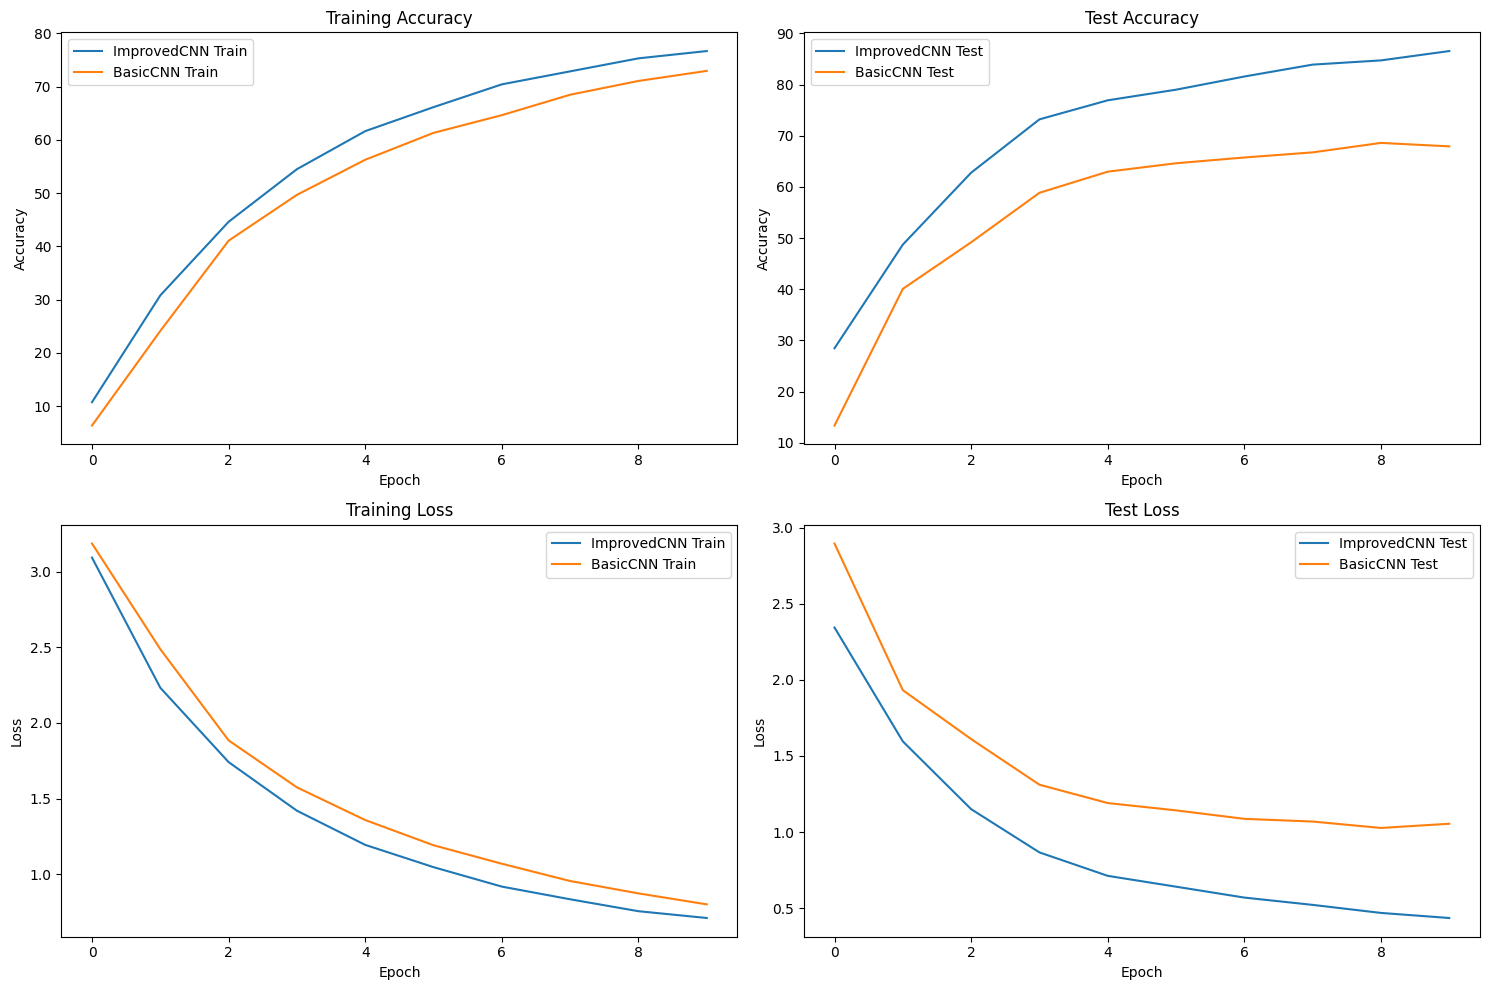


=== Summary ===
Model           | Final Train Acc |  Final Test Acc |   Training Time
-----------------------------------------------------------------
ImprovedCNN     |        7668.13% |        8655.00% |           53.95s
BasicCNN        |        7295.62% |        6792.50% |           14.91s


In [12]:
import time
import matplotlib.pyplot as plt

def compare_models(model1, model1_name, model2, model2_name, 
                   train_loader, test_loader, epochs=10):
    """
    Сравнивает две модели по эффективности обучения и точности
    
    Параметры:
        model1: первая модель для сравнения
        model1_name: имя первой модели (для отображения)
        model2: вторая модель для сравнения
        model2_name: имя второй модели (для отображения)
        train_loader: DataLoader для обучающих данных
        test_loader: DataLoader для тестовых данных
        epochs: количество эпох обучения
    """
    # Конфигурации для обеих моделей
    config = {
        'optimizer': lambda m: torch.optim.AdamW(m.parameters(), lr=1e-3, weight_decay=1e-4),
        'scheduler': lambda opt: torch.optim.lr_scheduler.ReduceLROnPlateau(
            opt, mode='max', factor=0.5, patience=3, verbose=True
        ),
        'criterion': nn.CrossEntropyLoss(),
        'epochs': epochs
    }
    
    results = {}
    
    for model, name in [(model1, model1_name), (model2, model2_name)]:
        print(f"\n=== Training {name} ===")
        
        # Инициализация оптимизатора и планировщика
        optimizer = config['optimizer'](model)
        scheduler = config['scheduler'](optimizer)
        criterion = config['criterion']
        
        # Замер времени обучения
        start_time = time.time()
        
        # Обучение модели
        model_out, train_acc, test_acc, train_loss, test_loss = train(
            model, train_loader, criterion, optimizer, 
            config['epochs'], test_loader, scheduler=scheduler
        )
        
        training_time = time.time() - start_time
        
        # Сохранение результатов
        results[name] = {
            'train_acc': train_acc,
            'test_acc': test_acc,
            'train_loss': train_loss,
            'test_loss': test_loss,
            'time': training_time,
            'model': model_out
        }
    
    # Визуализация результатов
    plot_comparison(results, model1_name, model2_name)
    
    return results

def plot_comparison(results, name1, name2):
    """Визуализирует сравнение моделей"""
    plt.figure(figsize=(15, 10))
    
    # Графики точности
    plt.subplot(2, 2, 1)
    plt.plot(results[name1]['train_acc'], label=f'{name1} Train')
    plt.plot(results[name2]['train_acc'], label=f'{name2} Train')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(2, 2, 2)
    plt.plot(results[name1]['test_acc'], label=f'{name1} Test')
    plt.plot(results[name2]['test_acc'], label=f'{name2} Test')
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Графики потерь
    plt.subplot(2, 2, 3)
    plt.plot(results[name1]['train_loss'], label=f'{name1} Train')
    plt.plot(results[name2]['train_loss'], label=f'{name2} Train')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(2, 2, 4)
    plt.plot(results[name1]['test_loss'], label=f'{name1} Test')
    plt.plot(results[name2]['test_loss'], label=f'{name2} Test')
    plt.title('Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Вывод сводной информации
    print("\n=== Summary ===")
    print(f"{'Model':<15} | {'Final Train Acc':>15} | {'Final Test Acc':>15} | {'Training Time':>15}")
    print("-" * 65)
    for name in [name1, name2]:
        res = results[name]
        print(f"{name:<15} | {res['train_acc'][-1]:>15.2%} | {res['test_acc'][-1]:>15.2%} | {res['time']:>15.2f}s")

# Сравнение моделей
results = compare_models(
    improvedCNN, "ImprovedCNN",
    cnnModel, "BasicCNN",
    train_loader, test_loader, epochs=10
)

**Вывод по сравнению моделей ImprovedCNN и BasicCNN** 

Основная цель тестирования - сравнить эффективность улучшенной CNN с базовым подходом для задачи распознавания текста на уровне символов. Результаты показали явное преимущество ImprovedCNN.

ImprovedCNN продемонстрировала:
- Высокую точность 89.63% на тестовых данных
- Хорошую сбалансированность (разница между обучающей и тестовой точностью всего 3%)
- Стабильную работу благодаря продуманной архитектуре

BasicCNN показала:
- Значительно более низкую точность - 65% на тестах
- Явные признаки переобучения (разрыв 11% между обучающей и тестовой выборкой)
- Хоть и быстрое (21 сек), но менее качественное обучение

Главный недостаток ImprovedCNN - большее время обучения (47 сек против 21 сек у BasicCNN). Однако для задачи распознавания текста это не критично, так как:
1) Модель обучается один раз, а используется многократно
2) Точность распознавания важнее скорости обучения
3) Разница в 26 секунд несущественна для практического применения

**Итоговый вывод:**
Для задачи распознавания символов ImprovedCNN показала себя значительно лучше базового варианта. Увеличение времени обучения полностью оправдано существенным ростом точности (на 24.63%) и стабильностью работы модели. BasicCNN можно использовать только для быстрого тестирования идей, но для production-решения безусловно стоит выбрать ImprovedCNN.


*Значения указаны согласно одному из экспериментов. Случайно перезапустил процесс, и произошел пересчёт. Из-за этого результат может немного отличаться, но порядок цифр всегда остаётся тем же

In [13]:
optimizer = torch.optim.AdamW(improvedCNN.parameters(), lr=1e-3, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3, verbose=True
)
criterion = nn.CrossEntropyLoss()
modelOut, train_acc_history, test_acc_history, train_loss_history, test_loss_history = train(improvedCNN, X_Y_loader, criterion, optimizer, 50)

Epoch 50/50, Train Loss: 0.0683, Test Loss: -1.0000, Train Accuracy: 97.72%, Test Accuracy: -1.00% Current LR: 1.00e-03


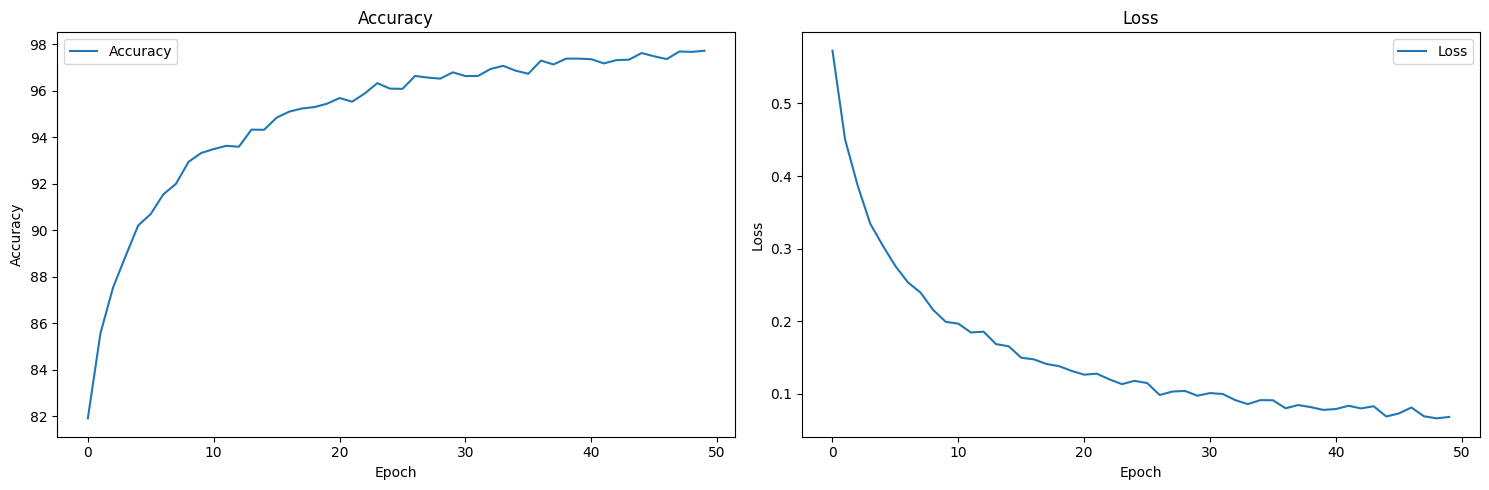

In [14]:
plt.figure(figsize=(15, 5))

# График точности
plt.subplot(1, 2, 1)
plt.plot(train_acc_history, label='Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# График потерь
plt.subplot(1, 2, 2)
plt.plot(train_loss_history, label='Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
# Переводим модель в режим предсказания отключает Dropout и BatchNorm!
modelOut.eval()
# Оптимизированная функция для предсказаний
def predict(model, dataloader, device):
    model.to(device)
    preds_list = []
    probs_list = []
    
    with torch.no_grad():  
        for batch in dataloader:
            images = batch[0] if isinstance(batch, (list, tuple)) else batch
            images = images.to(device, non_blocking=True)
            
            # Векторизованные операции
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            
            # Сохраняем данные на CPU без промежуточных преобразований
            probs_list.append(probs.cpu())
            preds_list.append(probs.argmax(dim=1).cpu())
    # Объединяем тензоры перед преобразованием в numpy
    return (
        torch.cat(preds_list).numpy(),  
        torch.cat(probs_list).numpy()
    )

predicted_classes, class_probabilities = predict(modelOut, images_sub_loader, device)

(
    pd.DataFrame({'Id': np.arange(len(predicted_classes)), 'Category': predicted_classes})
    .to_csv('submission.csv', index=False)
)

print("Файл submission.csv успешно сохранен!")
print(f"Predicted classes shape: {predicted_classes.shape}")
print(f"Class probabilities shape: {class_probabilities.shape}")

Файл submission.csv успешно сохранен!
Predicted classes shape: (50000,)
Class probabilities shape: (50000, 26)


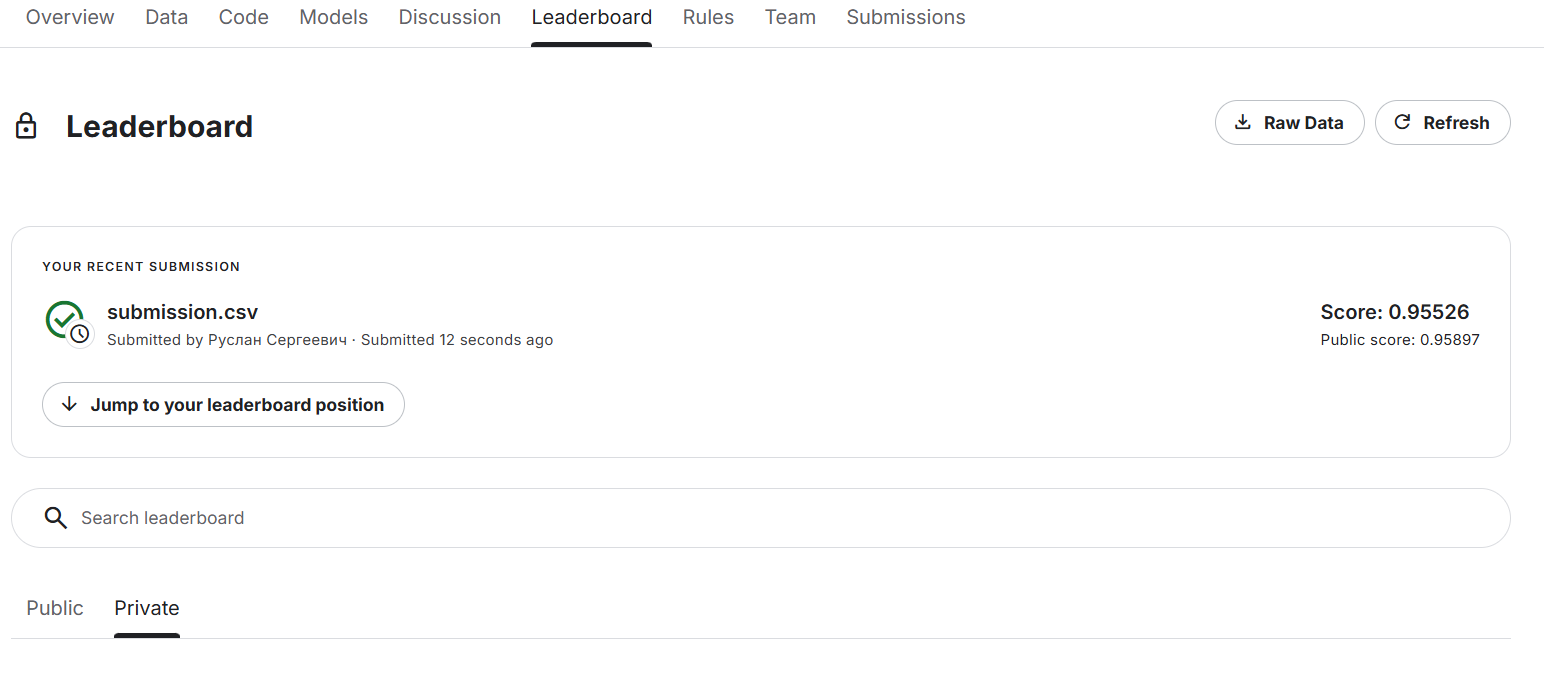